In [1]:
import os
from pathlib import Path
from math import ceil

import numpy as np
import pandas as pd
import sympy as sp
from sympy import symbols as s
from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from lab_tools import lab_round

%matplotlib widget

graph_path = Path("../images/").resolve()
table_path = Path("../tables/").resolve()
data_path = Path("../data/").resolve()

plt.style.use("./report.mplstyle")

Variabili

In [2]:
wave_length = 650 / 10**9

slit_name = 0.02
slit = slit_name / 10**3
slit_pos = 4 / 10**2

sensor_name = 1.5
sensor = sensor_name / 10**3
sensor_pos = 102.5 / 10**2

distance = sensor_pos - slit_pos

Load data

In [3]:
dfs = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(sensor_name) in file
]

# Scelti mettendo lo 0 a metà tra i primi minimi
dfs[0].y += 0.099
dfs[1].y += 0.099
dfs[2].y += 0.098
dfs[3].y += 0.099

Center sets on 0

(-0.03552703650000001, 1.3842208865)

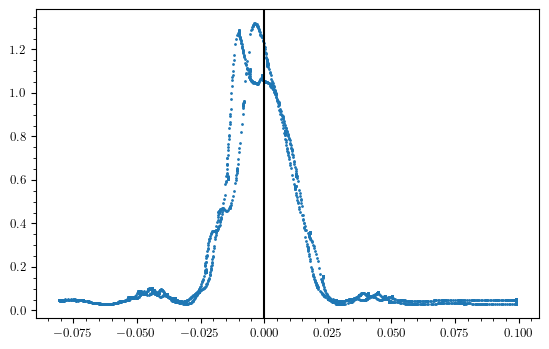

In [4]:
fig, ax = plt.subplots(1, 1)

df = dfs[3]
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Scatter graph

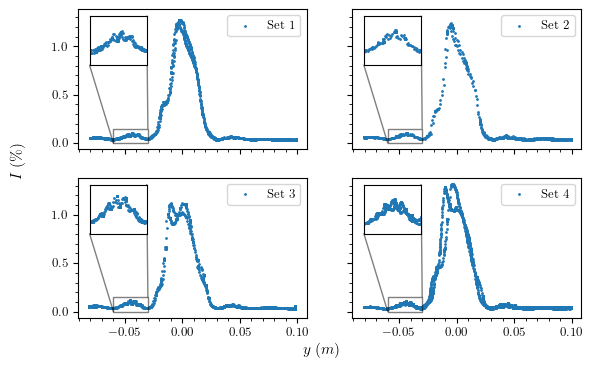

In [5]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = axs.flatten()

for i, df in enumerate(dfs):
    axs[i].scatter(df.y, df.I, s=1, label=f"Set {i+1}")
    axs[i].legend()
    zoom = axs[i].inset_axes([0.05, 0.6, 0.25, 0.35])

    zoom.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

    xlim = zoom.get_xlim()
    zoom.plot(xlim, [0.5, 0.5], color="black")

    zoom.set_xticklabels([])
    zoom.set_yticklabels([])
    zoom.tick_params(which='both' , bottom=False, left = False)
    zoom.set_xlim(-0.06, -0.03)
    zoom.set_ylim(0, 0.15)

    axs[i].indicate_inset_zoom(zoom, edgecolor="black")

fig.supxlabel(r"$y \; (m)$", size=mpl.rcParams['axes.labelsize'])
fig.supylabel(r"$I \; (\%)$", size=mpl.rcParams['axes.labelsize'])

fig.savefig(graph_path / f"single_scatter_{slit_name}.png")

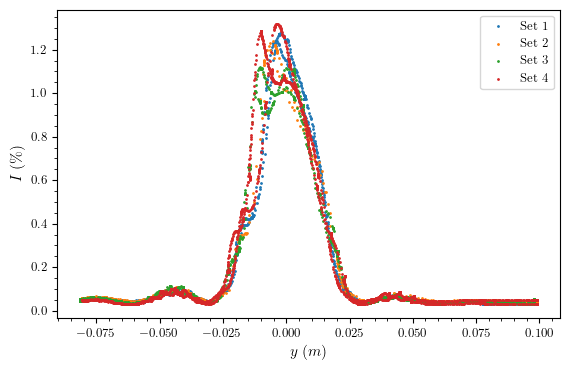

In [6]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"scatter_{slit_name}.png")

Find minimums

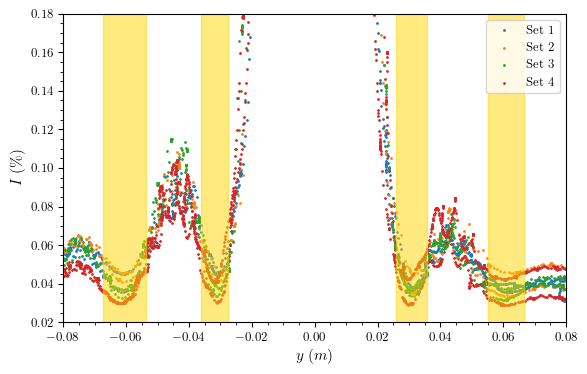

In [7]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

mins_left  = [-0.0675, -0.0362, 0.0259, 0.0551]
mins_right = [-0.0538, -0.0275, 0.0358, 0.0666]

ylim = ax.get_ylim()

for left, right in zip(mins_left, mins_right):
    ax.fill_betweenx(ylim, [left]*2, [right]*2, color="gold", alpha=0.5)


ax.set_ylim(0.02, 0.18)
ax.set_xlim(-0.08, 0.08)

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"min_{slit_name}.png")

Fenditura dai minimi

In [8]:
mins_df = pd.DataFrame()

mins_df['y'] = [
    (right + left) / 2
    for left, right in zip(mins_left, mins_right)
]
mins_df['dy'] = [
    abs(right - left) / 2
    for left, right in zip(mins_left, mins_right)
]

half_len = len(mins_df.index) / 2

mins_df['m'] = np.hstack([
    np.arange(-half_len, 0, dtype=np.int8),
    np.arange(1, half_len + 1, dtype=np.int8),
])

mins_df['l'] = mins_df.y / mins_df.m
mins_df['dl'] = abs(mins_df.dy / mins_df.m)

mins_df['a'] =  mins_df.apply(lambda r: wave_length * distance / r.l, axis=1)
mins_df['da'] =  mins_df.apply(lambda r: r.dl / r.l * r.a, axis=1)
mins_df['w'] = mins_df.da.to_numpy()**-2

print(
    np.average(mins_df.a, weights=mins_df.w),
    1 / np.sqrt(np.sum(mins_df.w))
)

mins_df

2.083046908577981e-05 1.2388122296932383e-06


,y,dy,m,l,dl,a,da,w
0,-0.06065,0.00685,-2,0.030325,0.003425,0.000021,0.000002,1.758664e+11
1,-0.03185,0.00435,-1,0.031850,0.004350,0.000020,0.000003,1.326661e+11
2,0.03085,0.00495,1,0.030850,0.004950,0.000021,0.000003,9.018018e+10
3,0.06085,0.00575,2,0.030425,0.002875,0.000021,0.000002,2.528992e+11


Salva tabella degli a

In [9]:
mins_df_str = pd.concat([
    mins_df.m,
    lab_round.measure_series(mins_df.y, mins_df.dy),
    lab_round.measure_series(mins_df.a * 10**3, mins_df.da * 10**3),
], axis='columns')

mins_df_str.to_latex(
    table_path / f"mins_{slit_name}.tex",
    columns=['m', 'y', 'a'],
    header=[
        r"$m$",
        r"$y \; (\si{\m})$",
        r"$a \; (\si{\mm})$"
    ],
    column_format='cc|c',
    index=False,
    escape=False,
)

mins_df_str


C:\Users\mrmat\AppData\Local\Temp\ipykernel_14916\4017186410.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  mins_df_str.to_latex(


,m,y,a
0,-2,\num{-0.061+-0.007},\num{0.021+-0.002}
1,-1,\num{-0.032+-0.004},\num{0.020+-0.003}
2,1,\num{0.031+-0.005},\num{0.021+-0.003}
3,2,\num{0.061+-0.006},\num{0.0210+-0.0020}


Fit

In [10]:
I_expr = s('I_0') * sp.Pow( sp.sinc(
    sp.pi * s('a') / s(r'\lambda') * s('y')/s('L')
), 2) + s('c')

I_fit = sp.lambdify(
    [s('y'), s('I_0'), s('a'), s('c')],
    I_expr.evalf(
        subs = {
            s(r'\lambda'): wave_length,
            s('L'): distance,
        }
    )
)

I_expr

I_0*sinc(pi*a*y/(L*\lambda))**2 + c

Rumore e picco

In [11]:
I_max = 1
I_min = 1

for df in dfs:
    I_min = df.I.min() if df.I.min() < I_min else I_min
    I_max = df.I.max() if df.I.max() > I_max else I_max

I_max, I_min

(1.31968689, 0.02874756)

In [12]:
I_fitted, a_fitted, c_fitted = 0, 0, 0
for df in dfs:
    popt, pcov = curve_fit(I_fit, df.y, df.I, [I_max, slit, I_min])
    print(popt, np.sqrt(np.diag(pcov)))
    I_fitted += popt[0]
    a_fitted += popt[1]
    c_fitted += popt[2]

I_fitted /= len(dfs)
a_fitted /= len(dfs)
c_fitted /= len(dfs)

print(I_fitted)
print(a_fitted)
print(c_fitted)

[1.15191521e+00 2.21869228e-05 3.42408132e-02] [3.71957296e-03 7.68783349e-08 1.33143920e-03]
[1.12717349e+00 2.09090176e-05 3.55541905e-02] [7.33751271e-03 1.37268918e-07 2.00715668e-03]
[1.06336525e+00 1.97596915e-05 3.38876513e-02] [4.91716320e-03 9.25751430e-08 1.55524366e-03]
[1.12656500e+00 2.02348249e-05 3.16593309e-02] [4.94710240e-03 9.45020445e-08 1.90421653e-03]
1.117254740391409
2.0772614221187465e-05
0.03383549647043113


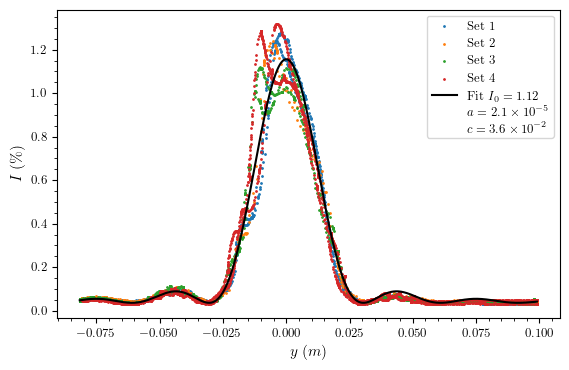

In [13]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

x = np.linspace(
    min([
        df.y.min()
        for df in dfs
    ]),
    max([
        df.y.max()
        for df in dfs
    ]),
    1000
)

ax.plot(x, I_fit(x, 1.12, 2.1e-5, 3.6e-2), color="black", label=r"Fit $I_0 = 1.12$ \par $a = 2.1 \times 10^{-5}$ \par $c = 3.6 \times 10^{-2}$")
# ax.plot(x, I_fit(x, I_fitted, a_fitted, c_fitted + 0.002))
# ax.plot(x, I_fit(x, I_fitted + 0.15, a_fitted - 0.2e-5, c_fitted + 0.01))
# ax.plot(x, I_fit(x, I_fitted - 0.15, a_fitted + 0.2e-5, c_fitted - 0.006))

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"fit_{slit_name}.png")

Scegli il miglior set a 1.5

In [14]:
df_15 = dfs[0]

df_10 = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(1.0) in file
][0]

df_10.y += 0.098

Centrare i nuovi set

(-0.0396911635, 0.9718200735)

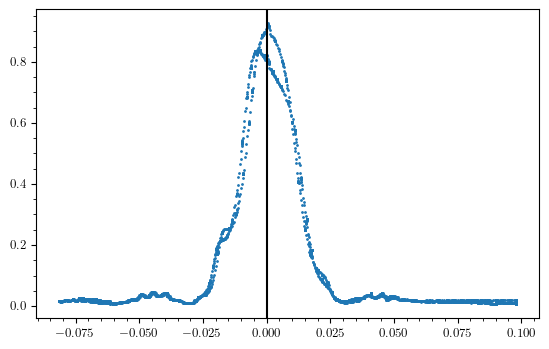

In [15]:
fig, ax = plt.subplots(1, 1)

df = df_10
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Confronto sensori

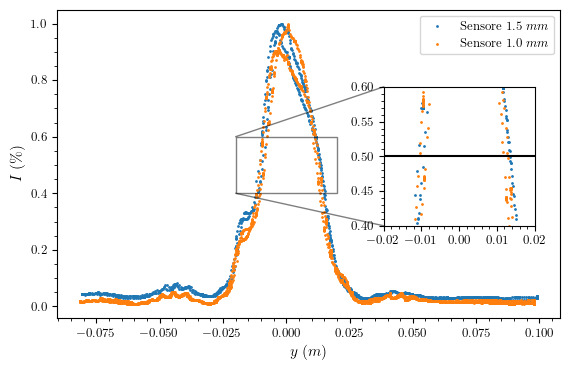

In [16]:
fig, ax = plt.subplots(1, 1)

ax.scatter(df_15.y, df_15.I / df_15.I.max(), s=1, label=r"Sensore $1.5 \; mm$")
ax.scatter(df_10.y, df_10.I / df_10.I.max(), s=1, label=r"Sensore $1.0 \; mm$")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

zoom = ax.inset_axes([0.65, 0.3, 0.3, 0.45])

zoom.scatter(df_15.y, df_15.I / df_15.I.max(), s=1, label=r"Sensore $1.5 \; mm$")
zoom.scatter(df_10.y, df_10.I / df_10.I.max(), s=1, label=r"Sensore $1.0 \; mm$")

xlim = zoom.get_xlim()
zoom.plot(xlim, [0.5, 0.5], color="black")

zoom.set_xlim(-0.02, 0.02)
zoom.set_ylim(0.4, 0.6)

ax.indicate_inset_zoom(zoom, edgecolor="black")

fig.savefig(graph_path / f"sensor_{slit_name}.png")

Confronto rumore con vari sensori

(<matplotlib.patches.Rectangle at 0x1e438fc7460>,
 (<matplotlib.patches.ConnectionPatch at 0x1e438fda920>,
  <matplotlib.patches.ConnectionPatch at 0x1e43901b1c0>))

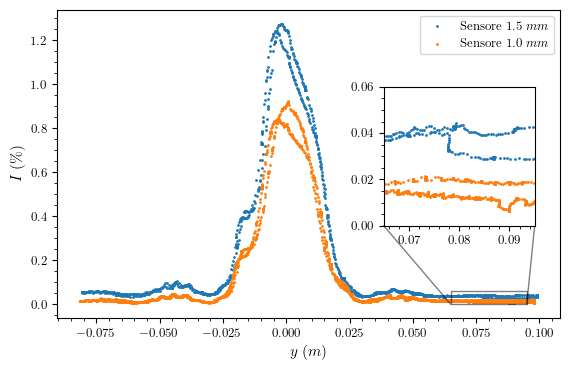

In [17]:
fig, ax = plt.subplots(1, 1)

ax.scatter(df_15.y, df_15.I, s=1, label=r"Sensore $1.5 \; mm$")
ax.scatter(df_10.y, df_10.I, s=1, label=r"Sensore $1.0 \; mm$")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

zoom = ax.inset_axes([0.65, 0.3, 0.3, 0.45])

zoom.scatter(df_15.y, df_15.I, s=1, label=r"Sensore $1.5 \; mm$")
zoom.scatter(df_10.y, df_10.I, s=1, label=r"Sensore $1.0 \; mm$")

xlim = zoom.get_xlim()
zoom.plot(xlim, [0.5, 0.5], color="black")

zoom.set_xlim(0.065, 0.095)
zoom.set_ylim(0, 0.06)

ax.indicate_inset_zoom(zoom, edgecolor="black")

Trasformata di Fourier

In [18]:
for df in dfs:
    X = np.fft.fft(df.sort_values('y').I)